# Task 2 - LSTM for time series classification

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
sns.set_style("darkgrid")
sns.set(font_scale=1.3)

## Data import & EDA

In [3]:
DATA_PATH = 'data'
FILE_NAME_PREFIX = 'Ambient_Living_'
N_FILES = len(list(filter(lambda s: s.endswith('.csv'), os.listdir(DATA_PATH)))) - 1  # one of the csv files contains targets

In [4]:
def load_file(file_code, strip=False):
    df = pd.read_csv(f'{DATA_PATH}/{FILE_NAME_PREFIX}{file_code}.csv')
    
    if strip:
        df.columns = [c.strip() for c in df.columns]
    
    return df

### Data example

In [5]:
seq_id = 1
data_example = load_file(seq_id)
data_example.head()

,Sensor 1,Sensor 2,Sensor 3,Sensor 4
0,-0.90476,-0.48,0.28571,0.30
1,-0.57143,-0.32,0.14286,0.30
2,-0.38095,-0.28,-0.14286,0.35
3,-0.28571,-0.20,-0.47619,0.35
4,-0.14286,-0.20,0.14286,-0.20


In [6]:
data_example.describe()

,Sensor 1,Sensor 2,Sensor 3,Sensor 4
count,27.000000,27.000000,27.000000,27.000000
mean,-0.232805,-0.082963,-0.077601,0.088889
std,0.216344,0.185614,0.240700,0.299465
min,-0.904760,-0.600000,-0.619050,-0.800000
25%,-0.309520,-0.200000,-0.285710,-0.075000
50%,-0.142860,-0.040000,-0.047619,0.150000
75%,-0.095238,0.040000,0.142860,0.325000
max,0.000000,0.160000,0.285710,0.500000


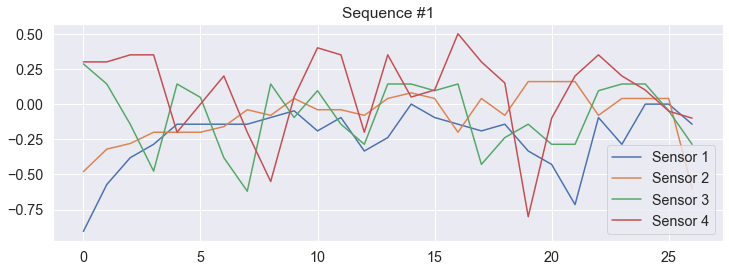

In [7]:
fig, ax = plt.subplots(figsize=(12,4))
ax = sns.lineplot(ax=ax, data=data_example, dashes=False)
_ = ax.set_title(f"Sequence #{seq_id}")

### Targets - class labels

In [8]:
targets = load_file('target', True)
targets.head()

,#sequence_ID,class_label
0,1,1
1,2,1
2,3,1
3,4,1
4,5,1


In [9]:
targets['class_label'].value_counts()  # number of classes, class labels, number of examples per class

-1    111
 1    105
Name: class_label, dtype: int64

### All data files

In [10]:
all_data = {i: load_file(i) for i in range(1, N_FILES+1)}


In [11]:
descr = targets['class_label'].to_frame()
descr.index=targets['#sequence_ID']
descr['length'] = [len(d) for d in all_data.values()]
descr.head()

,class_label,length
#sequence_ID,,
1,1,27
2,1,26
3,1,23
4,1,23
5,1,25


Text(0, 0.5, 'Count')

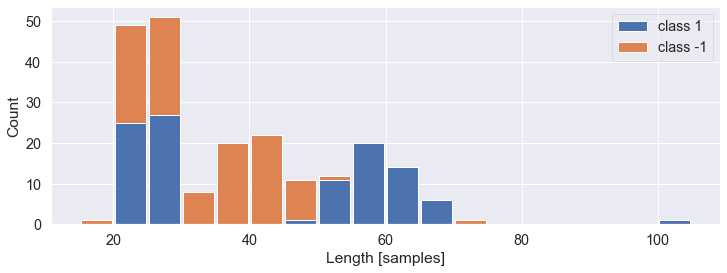

In [12]:
fig, ax = plt.subplots(figsize=(12,4))

w = 5
ln = descr['length']
labels_set = descr['class_label'].unique()

hist = ax.hist([ln[descr['class_label'] == label] for label in labels_set],
               bins=range(w*(min(ln)//w), max(ln)+w, w),
               label=[f'class {label}' for label in labels_set],
               stacked=True, rwidth=0.9)

ax.legend(fancybox=True, framealpha=0.5)
ax.set_xlabel("Length [samples]")
ax.set_ylabel("Count")